Creating Clusters

In [2]:
import pandas as pd
import numpy as np
import math as mh
import datetime as dt
import sklearn
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from datetime import datetime
import statsmodels.tsa.stattools as ts
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
cnsmpn= pd.read_csv("US_Cnsm.csv", dtype= {'Zone' : str,'Plant_Mat' : str,'MvT' : str,'Material' : str,'Plnt' : str,'SLoc' : str,'Crcy' : str,'Amount_LC' : np.float64,'Quantity' : np.float64,'Pstng_Date' : str,'Mat_type' : str,'Year' : int,'Month' : str,
}, parse_dates = ['Pstng_Date', 'Month'] ,na_filter=True)

In [3]:
cnsmpn= pd.read_csv("USCnsm_261.csv", parse_dates = ['Month'])

In [4]:
cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice
0,1062752,261.0,2014-03-01,2,141,70.5
1,1324574,261.0,2015-07-01,1,28,28.0
2,1278928,261.0,2015-04-01,3,15,5.0
3,1154349,261.0,2016-12-01,1,9,9.0
4,1134356,261.0,2015-11-01,1,2,2.0


In [5]:
cnsmpn.dtypes

Material              int64
MvT                 float64
Month        datetime64[ns]
Quantity              int64
Amount                int64
UnitPrice           float64
dtype: object

In [6]:
cnsmpn.shape

(738861, 6)

In [7]:
cnsmpn = cnsmpn[cnsmpn['Quantity'] > 0]

In [8]:
cnsmpn = cnsmpn[cnsmpn['Amount'] > 0]

In [9]:
test=pd.DataFrame(cnsmpn.groupby(['Material'])['Quantity'].count()>1)

In [10]:
test=test.reset_index()
test.head()

,Material,Quantity
0,1007744,True
1,1007745,True
2,1007747,True
3,1007748,True
4,1007749,True


In [11]:
test.columns= ['Material', 'TestTF']


In [12]:
test.head()

,Material,TestTF
0,1007744,True
1,1007745,True
2,1007747,True
3,1007748,True
4,1007749,True


In [13]:
cnsmpn= cnsmpn.merge(test, on= 'Material', how= 'left')

In [14]:
cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice,TestTF
0,1062752,261.0,2014-03-01,2,141,70.5,True
1,1324574,261.0,2015-07-01,1,28,28.0,True
2,1278928,261.0,2015-04-01,3,15,5.0,True
3,1154349,261.0,2016-12-01,1,9,9.0,True
4,1134356,261.0,2015-11-01,1,2,2.0,True


In [15]:
cnsmpn= cnsmpn[cnsmpn['TestTF']==True]

In [16]:
cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice,TestTF
0,1062752,261.0,2014-03-01,2,141,70.5,True
1,1324574,261.0,2015-07-01,1,28,28.0,True
2,1278928,261.0,2015-04-01,3,15,5.0,True
3,1154349,261.0,2016-12-01,1,9,9.0,True
4,1134356,261.0,2015-11-01,1,2,2.0,True


In [17]:
cnsmpn=cnsmpn.drop(['TestTF'], axis=1)

In [18]:
cnsmpn.shape

(699724, 6)

In [19]:
cnsmpn.describe()

,Material,MvT,Quantity,Amount,UnitPrice
count,6.997240e+05,699724.0,6.997240e+05,6.997240e+05,699724.000000
mean,1.291687e+06,261.0,4.029053e+01,2.025612e+04,178.332957
std,2.229870e+05,0.0,1.439836e+04,1.043458e+07,745.138450
min,1.007744e+06,261.0,1.000000e+00,1.000000e+00,0.005000
25%,1.091992e+06,261.0,1.000000e+00,1.400000e+01,4.500000
50%,1.247281e+06,261.0,2.000000e+00,5.900000e+01,20.000000
75%,1.457609e+06,261.0,5.000000e+00,2.410000e+02,98.000000
max,1.819233e+06,261.0,1.155646e+07,7.803848e+09,83420.000000


In [20]:
K=(cnsmpn.groupby(['Material'])['Month'].max()-cnsmpn.groupby(['Material'])['Month'].min()).astype('timedelta64[D]')

In [21]:
K=pd.DataFrame(K)

In [22]:
K=K.reset_index()

In [23]:
K.columns= ['Material', 'Diff']

In [24]:
cnsmpn=cnsmpn.iloc[:,:13]

In [26]:
cnsmpn= cnsmpn.merge(K, on= 'Material',how='left')

In [27]:
cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice,Diff
0,1062752,261.0,2014-03-01,2,141,70.5,1157.0
1,1324574,261.0,2015-07-01,1,28,28.0,1583.0
2,1278928,261.0,2015-04-01,3,15,5.0,1673.0
3,1154349,261.0,2016-12-01,1,9,9.0,700.0
4,1134356,261.0,2015-11-01,1,2,2.0,1583.0


In [28]:
L=cnsmpn.groupby(['Material'])['Quantity'].sum()
L=pd.DataFrame(L)
L=L.reset_index()
L.columns= ['Material', 'TotalQuantity']
cnsmpn= cnsmpn.merge(L, on= 'Material',how='left')

In [29]:
cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice,Diff,TotalQuantity
0,1062752,261.0,2014-03-01,2,141,70.5,1157.0,12
1,1324574,261.0,2015-07-01,1,28,28.0,1583.0,39
2,1278928,261.0,2015-04-01,3,15,5.0,1673.0,65
3,1154349,261.0,2016-12-01,1,9,9.0,700.0,5
4,1134356,261.0,2015-11-01,1,2,2.0,1583.0,19


In [30]:
cnsmpn['Frequency']= cnsmpn['Diff']/cnsmpn['TotalQuantity']

In [31]:
 cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice,Diff,TotalQuantity,Frequency
0,1062752,261.0,2014-03-01,2,141,70.5,1157.0,12,96.416667
1,1324574,261.0,2015-07-01,1,28,28.0,1583.0,39,40.589744
2,1278928,261.0,2015-04-01,3,15,5.0,1673.0,65,25.738462
3,1154349,261.0,2016-12-01,1,9,9.0,700.0,5,140.000000
4,1134356,261.0,2015-11-01,1,2,2.0,1583.0,19,83.315789


In [32]:
clstrdata=cnsmpn[['UnitPrice','Frequency']]

In [33]:
clstrdata.head()

,UnitPrice,Frequency
0,70.5,96.416667
1,28.0,40.589744
2,5.0,25.738462
3,9.0,140.000000
4,2.0,83.315789


In [34]:
X = StandardScaler().fit_transform(clstrdata)

In [35]:
clstrdata=pd.DataFrame(X)

In [36]:
clstrdata.head()

,0,1
0,-0.144715,0.322706
1,-0.201752,-0.299242
2,-0.232619,-0.464695
3,-0.227250,0.808253
4,-0.236645,0.176754


In [37]:
clstrdata.columns= ['UnitPrice','Frequency']

In [38]:
clstrdata.head()

,UnitPrice,Frequency
0,-0.144715,0.322706
1,-0.201752,-0.299242
2,-0.232619,-0.464695
3,-0.227250,0.808253
4,-0.236645,0.176754


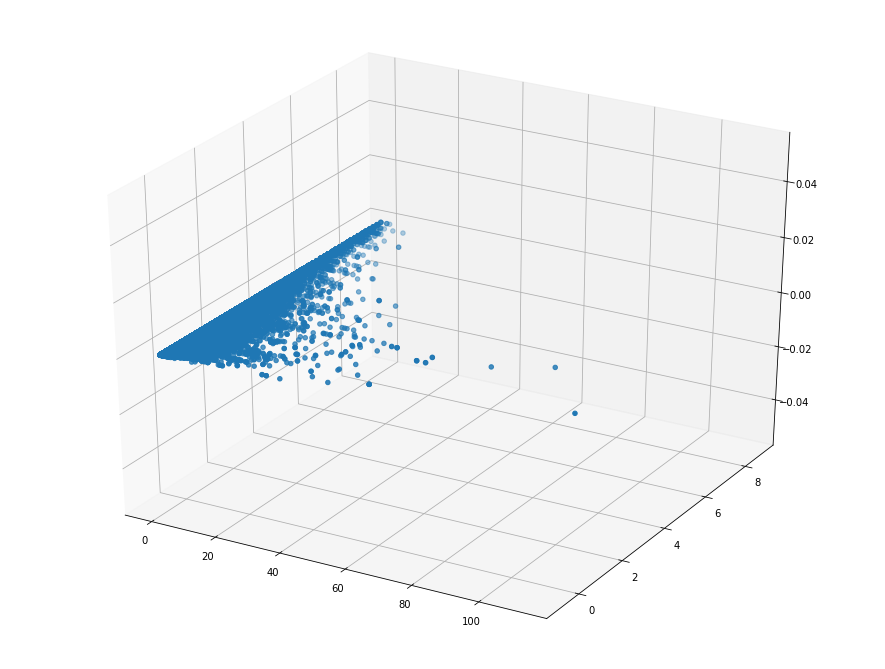

In [102]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(clstrdata['UnitPrice'],clstrdata['Frequency'])

In [41]:
sse = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(clstrdata)
    clstrdata["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ 

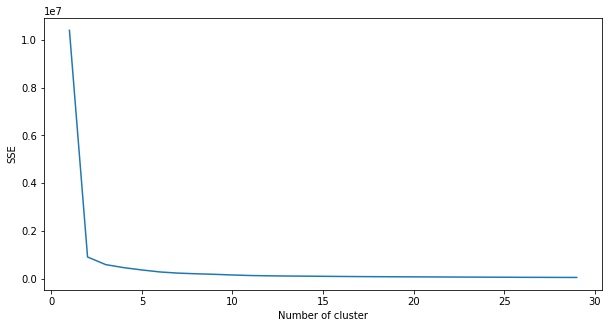

In [50]:
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [51]:
clstrdataNew= cnsmpn[['UnitPrice','Frequency']]

In [52]:
clstrdataNew.head()

,UnitPrice,Frequency
0,70.5,96.416667
1,28.0,40.589744
2,5.0,25.738462
3,9.0,140.000000
4,2.0,83.315789


In [54]:

kmeans = KMeans(n_clusters=10, random_state=0).fit(clstrdataNew)

In [55]:
cnsmpn['ClusterID']= kmeans.predict(cnsmpn[['UnitPrice','Frequency']])

In [56]:
pd.unique(cnsmpn['ClusterID'])

array([0, 9, 6, 2, 4, 7, 1, 3, 8, 5], dtype=int64)

In [57]:
cnsmpn.head()

,Material,MvT,Month,Quantity,Amount,UnitPrice,Diff,TotalQuantity,Frequency,ClusterID
0,1062752,261.0,2014-03-01,2,141,70.5,1157.0,12,96.416667,0
1,1324574,261.0,2015-07-01,1,28,28.0,1583.0,39,40.589744,0
2,1278928,261.0,2015-04-01,3,15,5.0,1673.0,65,25.738462,0
3,1154349,261.0,2016-12-01,1,9,9.0,700.0,5,140.000000,0
4,1134356,261.0,2015-11-01,1,2,2.0,1583.0,19,83.315789,0


In [58]:
cnsmpnClstr1= cnsmpn[cnsmpn['ClusterID']==0]
cnsmpnClstr2= cnsmpn[cnsmpn['ClusterID']==1]
cnsmpnClstr3= cnsmpn[cnsmpn['ClusterID']==2]
cnsmpnClstr4= cnsmpn[cnsmpn['ClusterID']==3]
cnsmpnClstr5= cnsmpn[cnsmpn['ClusterID']==4]
cnsmpnClstr6= cnsmpn[cnsmpn['ClusterID']==5]
cnsmpnClstr7= cnsmpn[cnsmpn['ClusterID']==6]
cnsmpnClstr8= cnsmpn[cnsmpn['ClusterID']==7]
cnsmpnClstr9= cnsmpn[cnsmpn['ClusterID']==9]
cnsmpnClstr10= cnsmpn[cnsmpn['ClusterID']==10]

In [59]:
print(cnsmpnClstr1.shape)
print(cnsmpnClstr2.shape)
print(cnsmpnClstr3.shape)
print(cnsmpnClstr4.shape)
print(cnsmpnClstr5.shape)
print(cnsmpnClstr6.shape)
print(cnsmpnClstr7.shape)
print(cnsmpnClstr8.shape)
print(cnsmpnClstr9.shape)
print(cnsmpnClstr10.shape)

(507906, 10)
(854, 10)
(6263, 10)
(273, 10)
(42595, 10)
(18, 10)
(15737, 10)
(2293, 10)
(123695, 10)
(0, 10)


In [66]:
cnsmpnClstr3

,Zone,Plant_Mat,MvT,Material,Plnt,SLoc,Crcy,Amount_LC,Quantity,Pstng_Date,Mat_type,Year,Month,Diff,TotalQuantity,Frequency,ClusterID
1396925,US,51121756894,261.00,1756894,5112,88,USD,3.212108e+09,1756889.0,2017-09-16,ERSA,2017,2017-01-09,724.0,2277660.88,0.000318,2


In [60]:
col = np.where(cnsmpn['ClusterID']==1,'k',np.where(cnsmpn['ClusterID']==0,'r',np.where(cnsmpn['ClusterID']==2,'b',np.where(cnsmpn['ClusterID']==3,'g',np.where(cnsmpn['ClusterID']==4,'y',np.where(cnsmpn['ClusterID']==5,'m',np.where(cnsmpn['ClusterID']==4,'w','c')))))))

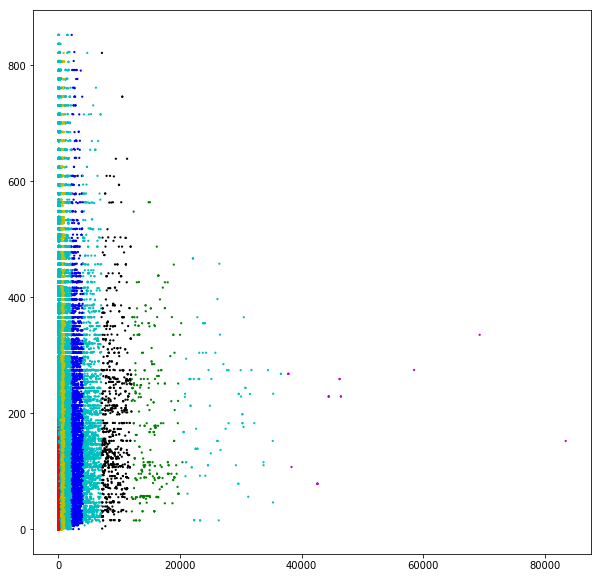

In [61]:
plt.scatter(cnsmpn['UnitPrice'],cnsmpn['Frequency'] , c=col, s=5, linewidth=0)
plt.show()

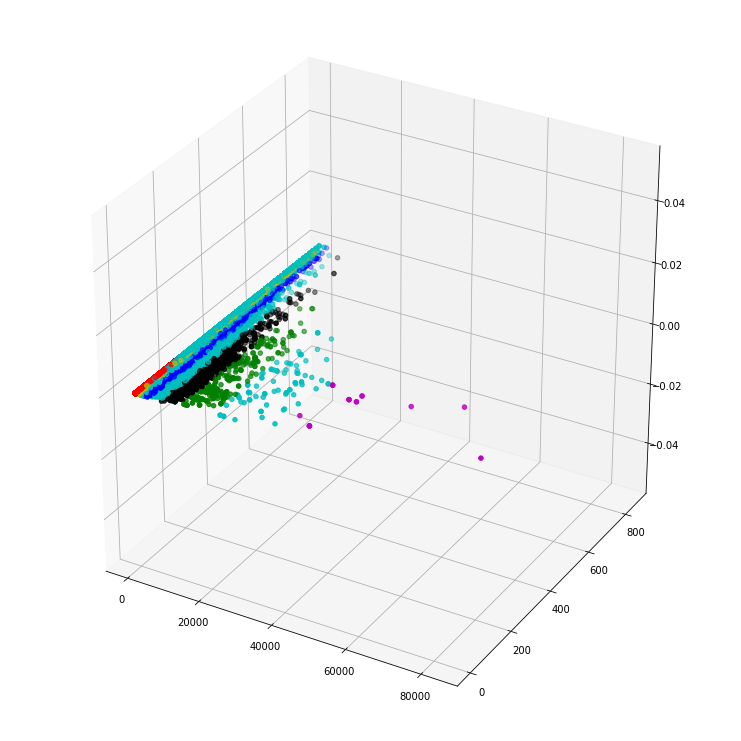

In [77]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(cnsmpn['UnitPrice'],cnsmpn['Frequency'], c=col)